In [5]:
import pandas as pd
import dask.dataframe as dd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

# Paths

In [6]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_svm_csv = os.path.join(processed_dir, 'minority_users_svm.csv')
minority_users_svm_smote_csv = os.path.join(processed_dir, 'minority_users_svm_smote.csv')

Import Dataset

In [9]:
# Read the multi-part Parquet dataset
fds = pd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
__null_dask_index__,,,,,,,,,,,,,,,,,,,
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False


# Decision Tree / Random Forest

In [10]:
X = fds.drop(columns = ['user', 'malicious'])
y = fds.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({False: 1574, True: 26})


**SMOTE Oversampling**

In [11]:
# transform the dataset
oversample = SMOTE(sampling_strategy = 0.4, random_state = 42) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({False: 1574, True: 629})


**Feature Normalisation**

In [12]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(resampled_X_train)
X_test_scaled = scaler.transform(X_test)

y_train = resampled_y_train

**Model Evaluation**

Accuracy: 97.25%
Precision = 11.11%
Recall = 25.00%
f-1 score = 15.38%

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       396
        True       0.11      0.25      0.15         4

    accuracy                           0.97       400
   macro avg       0.55      0.61      0.57       400
weighted avg       0.98      0.97      0.98       400



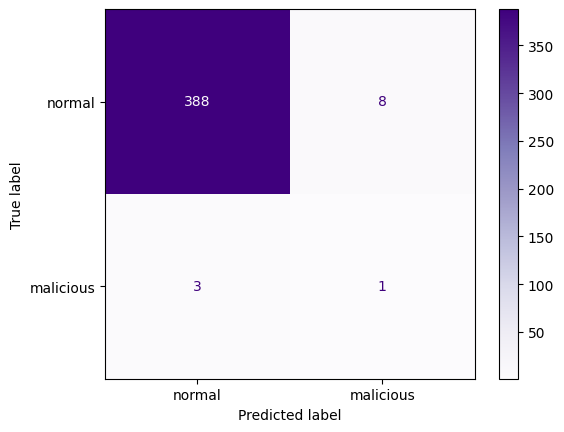

In [13]:
dt = DecisionTreeClassifier(random_state = 42)

# Evaluate the model
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision = {:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall = {:.2f}%".format(recall_score(y_test, y_pred)*100))
print("f-1 score = {:.2f}%".format(f1_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Purples)
plt.show()

**Hyperparameter Tuning**

In [14]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 3, 5],
    # 'criterion': ['gini', 'entropy', 'log_loss'], gini
    # 'splitter': ['best', 'random'], best
    'max_features': ['sqrt', 'log', None],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2], 0
    # 'max_leaf_nodes': [None, 2, 4],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2], 0
    'class_weight': ['balanced', None],
    'ccp_alpha': [0.0, 0.01, 0.2]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_dt = grid_search.best_estimator_
test_score = best_dt.score(X_test_scaled, y_test)
print("Test Set Score:", test_score)


Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Score: 0.9809379509379511
Test Set Score: 0.9725


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\b

**Model Evaluation after Tuning**

Accuracy: 97.25%
Precision = 18.18%
Recall = 50.00%
f-1 score = 26.67%

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       396
        True       0.18      0.50      0.27         4

    accuracy                           0.97       400
   macro avg       0.59      0.74      0.63       400
weighted avg       0.99      0.97      0.98       400



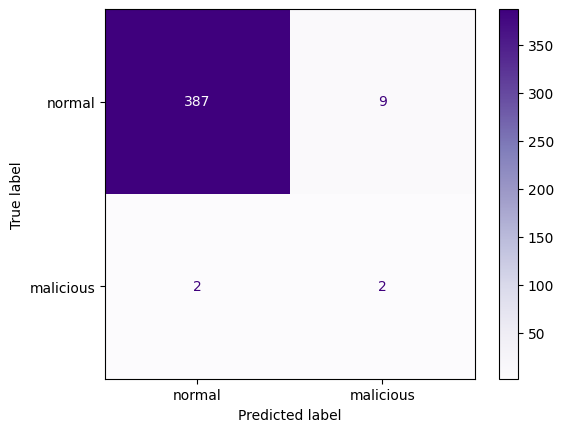

In [15]:
# Evaluate the model
best_dt.fit(X_train_scaled, y_train)
y_pred = best_dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision = {:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall = {:.2f}%".format(recall_score(y_test, y_pred)*100))
print("f-1 score = {:.2f}%".format(f1_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Purples)
plt.show()

AUC score: 0.7386363636363636


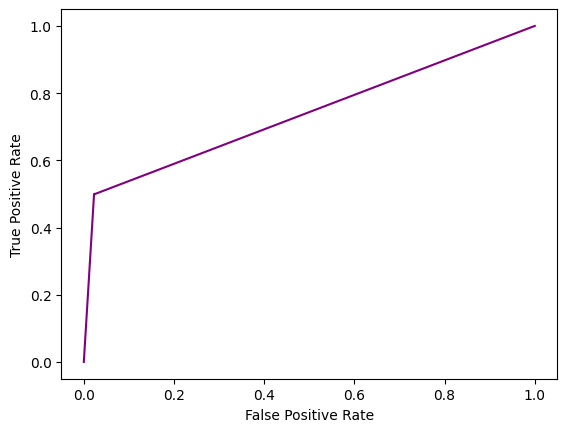

In [16]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(dt_fpr, dt_tpr, color = "purple", label = "Decision Tree")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

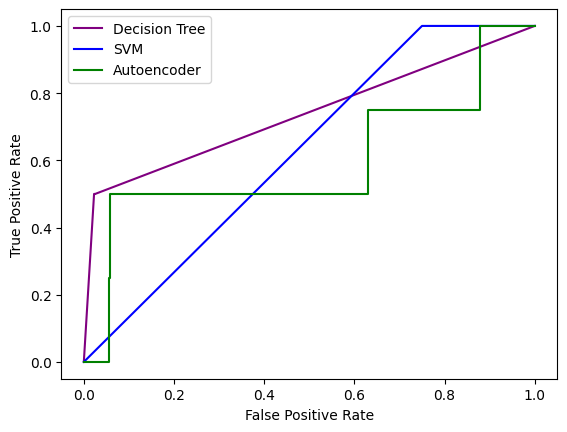

In [35]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(dt_fpr, dt_tpr, color = "purple", label = "Decision Tree")

    svm_fpr = np.array([0,0.75,1])
    svm_tpr = np.array([0,1,1])
    plt.plot(svm_fpr, svm_tpr, color = "blue", label = "SVM")

    ae_fpr = np.array([0,0.00252525,0.05555556, 0.05555556, 0.05808081, 0.05808081, 0.63131313, 0.63131313, 0.87878788, 0.87878788, 1])
    ae_tpr = np.array([0,0,0,0.25,0.25, 0.5, 0.5, 0.75, 0.75, 1, 1])
    plt.plot(ae_fpr, ae_tpr, color = "green", label = "Autoencoder")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

plot_roc_curve(y_test, y_pred)

**Feature Importance**

<Axes: >

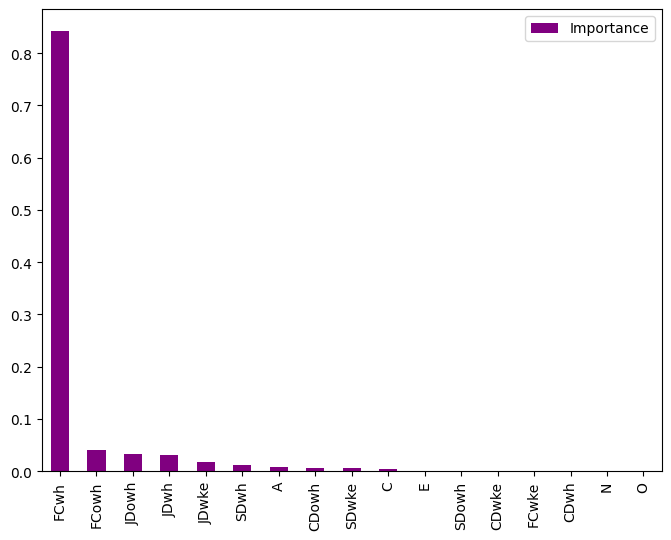

In [24]:
feat_importances = pd.DataFrame(best_dt.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6), color = "purple")

**Visualise Graph**

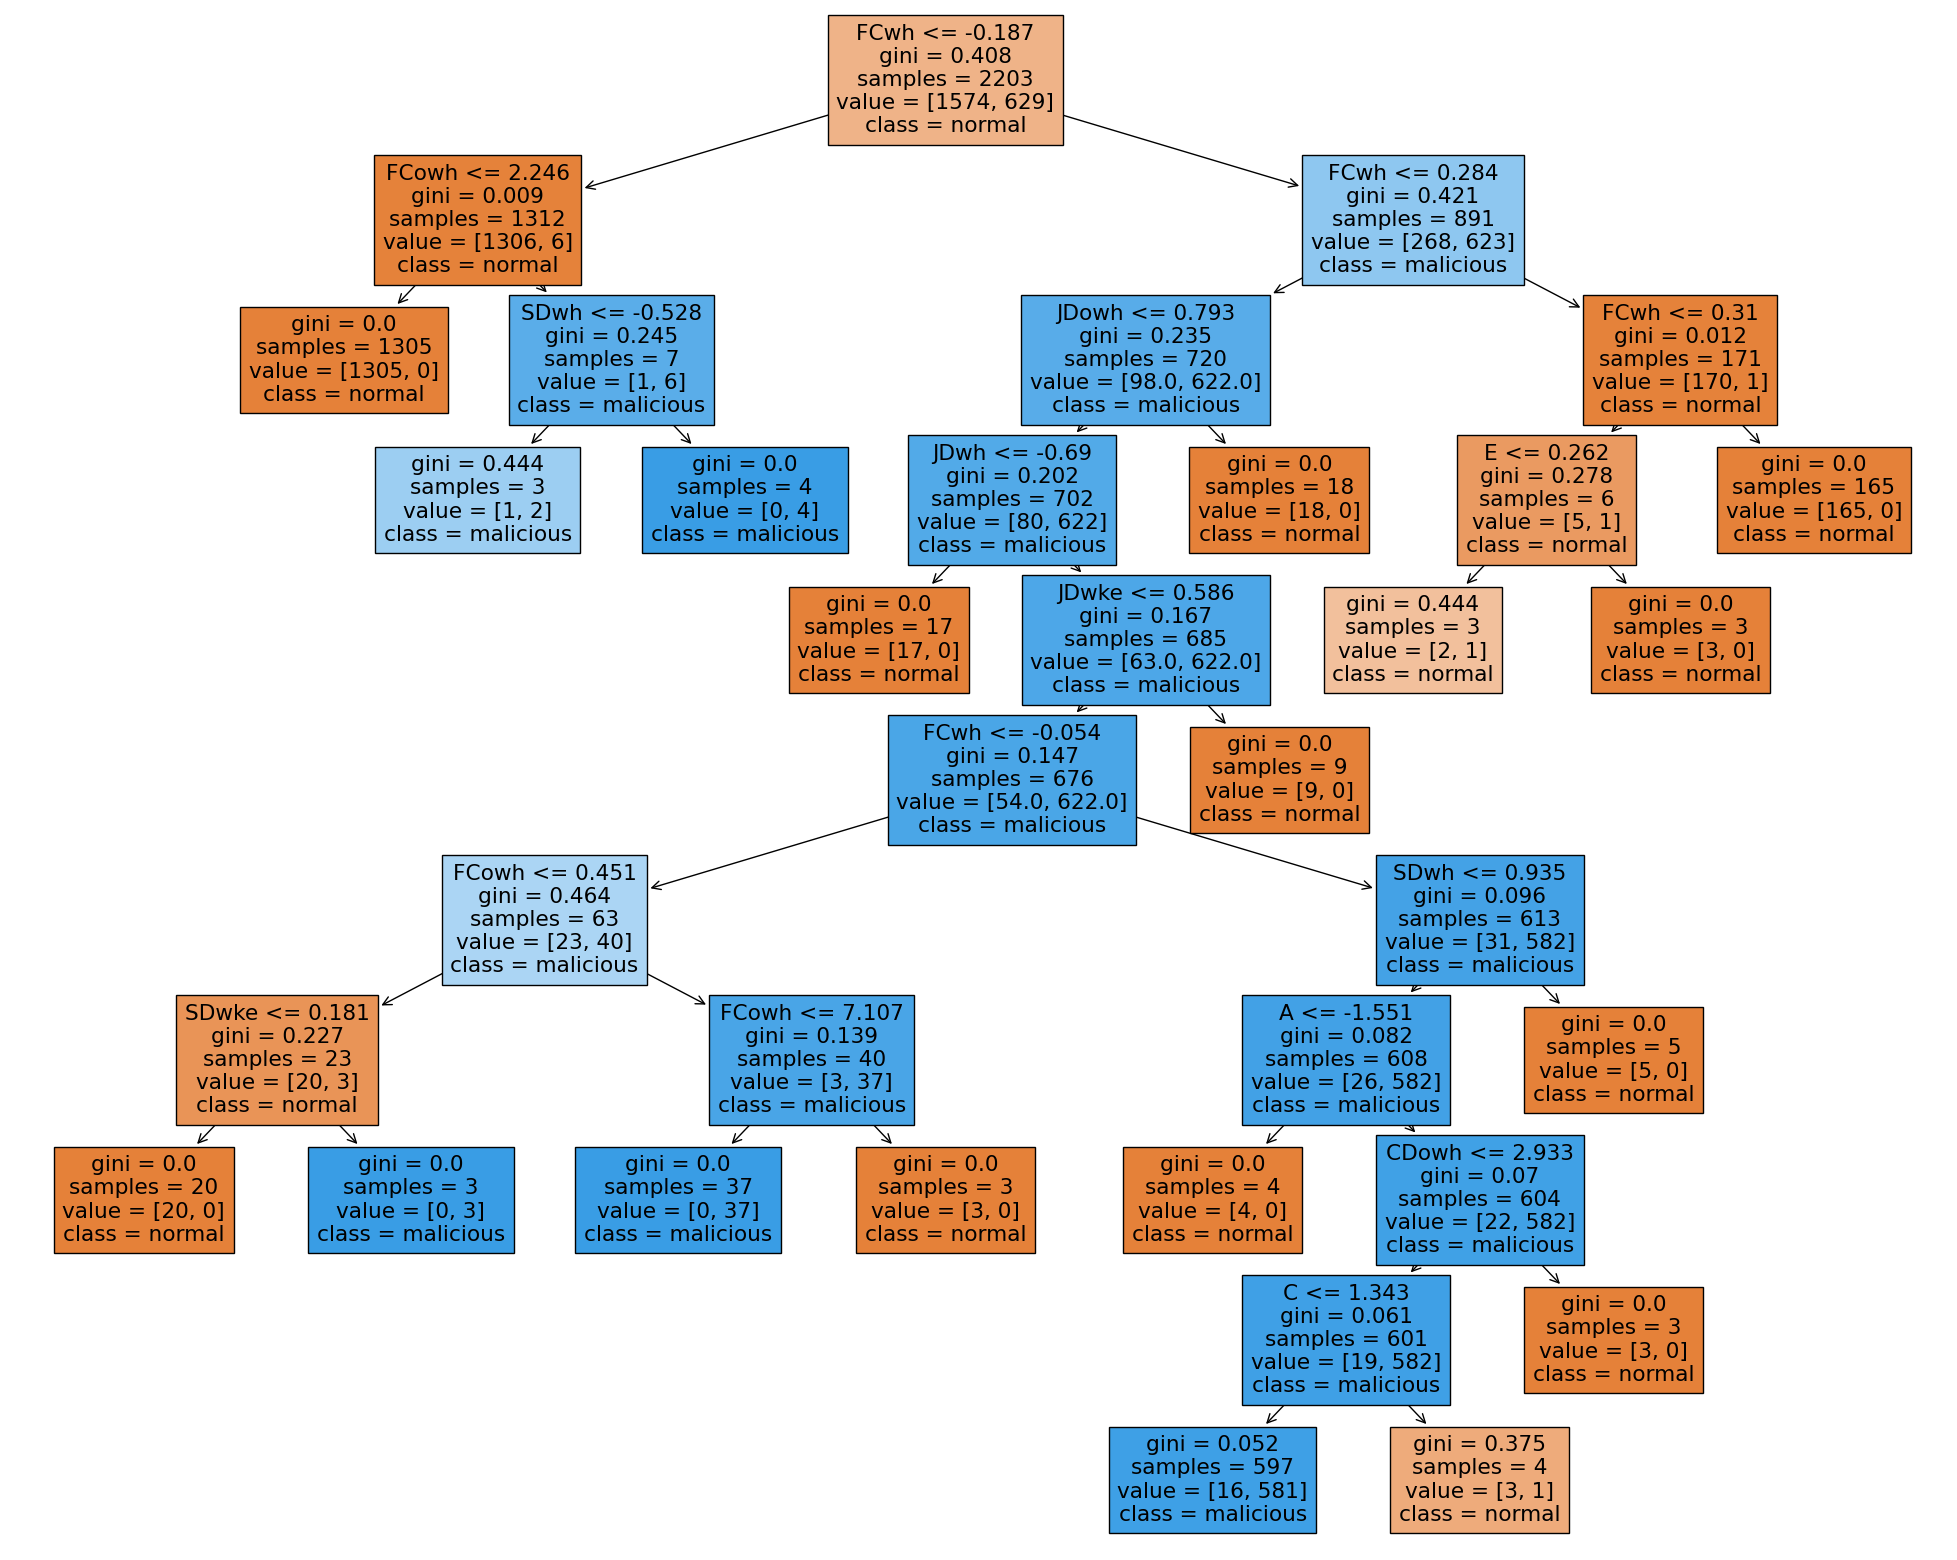

In [26]:


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns.tolist(),  
                   class_names=["normal","malicious"],
                   filled=True)

**Confidence Score: Using Gini**
- A higher impurity indicates a higher risk or uncertainty in the classification decision made by that node. Hence, lower confidence score
- Sum Gini at nodes in decision path, weighted according to number of samples in a node

In [13]:


def get_decision_paths(clf, X):
    node_indicator = clf.decision_path(X)
    decision_paths_matrix = node_indicator.toarray()
    decision_paths_nodes = list([np.where(row == 1)[0].tolist() for row in decision_paths_matrix])

    return decision_paths_nodes
    
def multiply_gini(clf, decision_paths):
    gini_paths = []

    for path in decision_paths:
        gini_nodes = []

        for node in path:
            gini_nodes.append(clf.tree_.n_node_samples[node] * clf.tree_.impurity[node])
        
        gini_paths.append(sum(gini_nodes))

    return np.array(gini_paths).reshape(-1, 1)

def get_confidence_score(clf, decision_paths):
    
    gini = multiply_gini(best_dt, decision_paths)
    scalar = MinMaxScaler(feature_range=(0, 1))
    risk_scores = scalar.fit_transform(gini) # 0 means low risk, 1 means high risk
    confidence_scores = 1 - risk_scores # o means low confidence, 1 means high confidence

    return confidence_scores

[0.         0.02678481 0.06139143 0.09970162 0.14467942 0.1664636
 0.16676415 0.28766249 0.39104472 0.51914461 0.6676365  0.6688413
 0.6703473  0.99724618 0.99845097 1.        ]


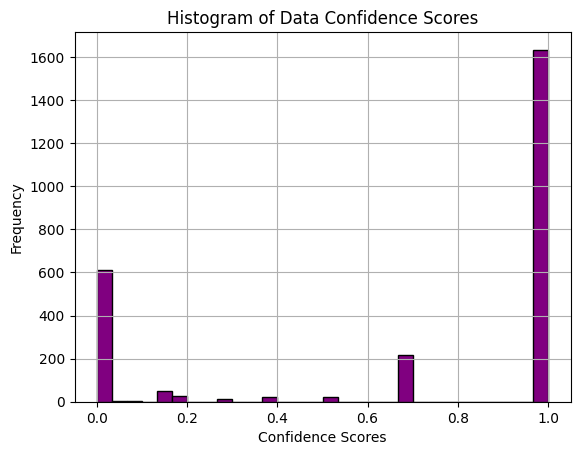

In [27]:
# Combine train and test data sets obtain all risk scores
train_decision_paths = get_decision_paths(best_dt, X_train_scaled)
test_decision_paths = get_decision_paths(best_dt, X_test_scaled)

all_decision_paths = []
all_decision_paths.extend(train_decision_paths)
all_decision_paths.extend(test_decision_paths)

all_confidence_scores = get_confidence_score(best_dt, all_decision_paths)

# Plot histogram
plt.hist(all_confidence_scores, bins=30, edgecolor='black', color = "purple")  # Adjust bins as needed
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Data Confidence Scores')
plt.grid(True)
plt.show()

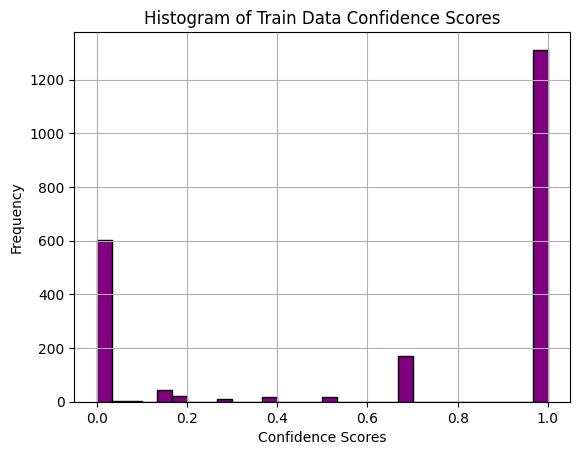

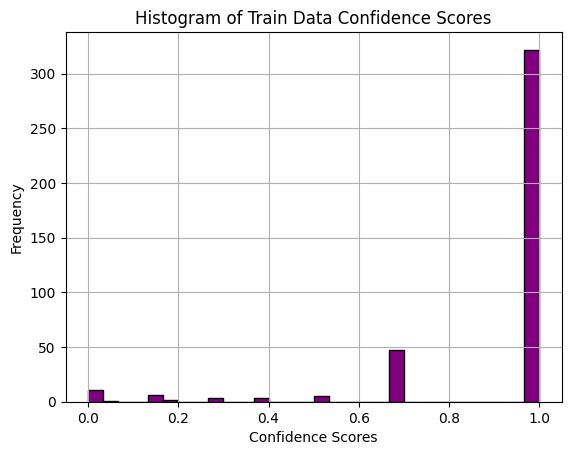

In [37]:
train_decision_paths = get_decision_paths(best_dt, X_train_scaled)
test_decision_paths = get_decision_paths(best_dt, X_test_scaled)


train_confidence_scores = get_confidence_score(best_dt, train_decision_paths)
test_confidence_scores = get_confidence_score(best_dt, test_decision_paths)

# Plot histogram
plt.hist(train_confidence_scores, bins=30, edgecolor='black', color = "purple")  # Adjust bins as needed
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Confidence Scores')
plt.grid(True)
plt.show()

plt.hist(test_confidence_scores, bins=30, edgecolor='black', color = "purple")  # Adjust bins as needed
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Confidence Scores')
plt.grid(True)
plt.show()

**Study Minority Instances**
- TP / FN / FP

Get data of minority users

In [15]:
def get_minority_tables(y_pred_value, y_test_value):
    
    # Get rows of minority data
    X_test_indices = np.where((y_pred == y_pred_value) & (y_test == y_test_value))
    minority_X_test = X_test.iloc[X_test_indices]
    minority_data = data.iloc[minority_X_test.index].reset_index(drop = True)
    
    # Get decision path
    minority_decision_paths = get_decision_paths(best_dt, X_test_scaled[X_test_indices])
    minority_data['decision_path'] = minority_decision_paths

    # Get confidence score
    minority_data['confidence_score'] = get_confidence_score(best_dt, minority_decision_paths)
    
    # Get probabilities of classification
    prob = best_dt.predict_proba(X_test_scaled[X_test_indices])
    probs_df = pd.DataFrame(prob, columns=['normal_prob', 'malicious_prob'])
    minority_data = pd.concat([minority_data, probs_df], axis=1)
    
    display(minority_data)

In [16]:
print("False Positives")
get_minority_tables(1, 0)

print("False Negatives")
get_minority_tables(0, 1)

print("True Positives")
get_minority_tables(1,1)

False Positives


,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,...,CDowh,CDwh,JDwke,JDowh,JDwh,malicious,decision_path,confidence_score,normal_prob,malicious_prob
0,MEB1743,33,39,18,33,30,0,86,307,0,...,5,14,0,91,272,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
1,GGD1545,41,37,38,22,25,0,51,225,0,...,9,29,0,229,672,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
2,KCR1118,36,36,17,25,39,0,121,308,0,...,0,6,0,16,55,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
3,GBV0440,31,12,10,44,21,0,4,250,0,...,23,443,0,16,338,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
4,MCV1046,46,39,27,35,29,0,16,188,0,...,10,39,0,19,112,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
5,NBL1490,18,15,30,23,22,0,11,254,0,...,0,0,0,112,2070,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
6,EAM1308,40,25,20,16,33,32,58,278,0,...,38,149,73,152,494,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
7,MKC0869,30,35,20,38,30,0,73,216,0,...,46,161,0,106,309,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
8,ERM1590,45,37,30,15,25,0,69,270,0,...,0,0,0,112,254,0,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199


False Negatives


,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,...,CDowh,CDwh,JDwke,JDowh,JDwh,malicious,decision_path,confidence_score,normal_prob,malicious_prob
0,TNB1616,33,38,10,43,29,0,12,61,0,...,9,15,0,123,248,1,"[0, 1, 2]",1.0,1.0,0.0
1,TMT0851,39,39,16,25,25,0,35,77,0,...,488,1491,0,311,816,1,"[0, 1, 2]",1.0,1.0,0.0


True Positives


,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,...,CDowh,CDwh,JDwke,JDowh,JDwh,malicious,decision_path,confidence_score,normal_prob,malicious_prob
0,OKM1092,11,34,38,15,27,0,105,244,0,...,1,8,0,108,232,1,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199
1,MCP0611,19,19,19,45,29,0,5,226,0,...,0,0,0,55,58,1,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",1.0,0.026801,0.973199


Colour code this decision tree and refer to node value 

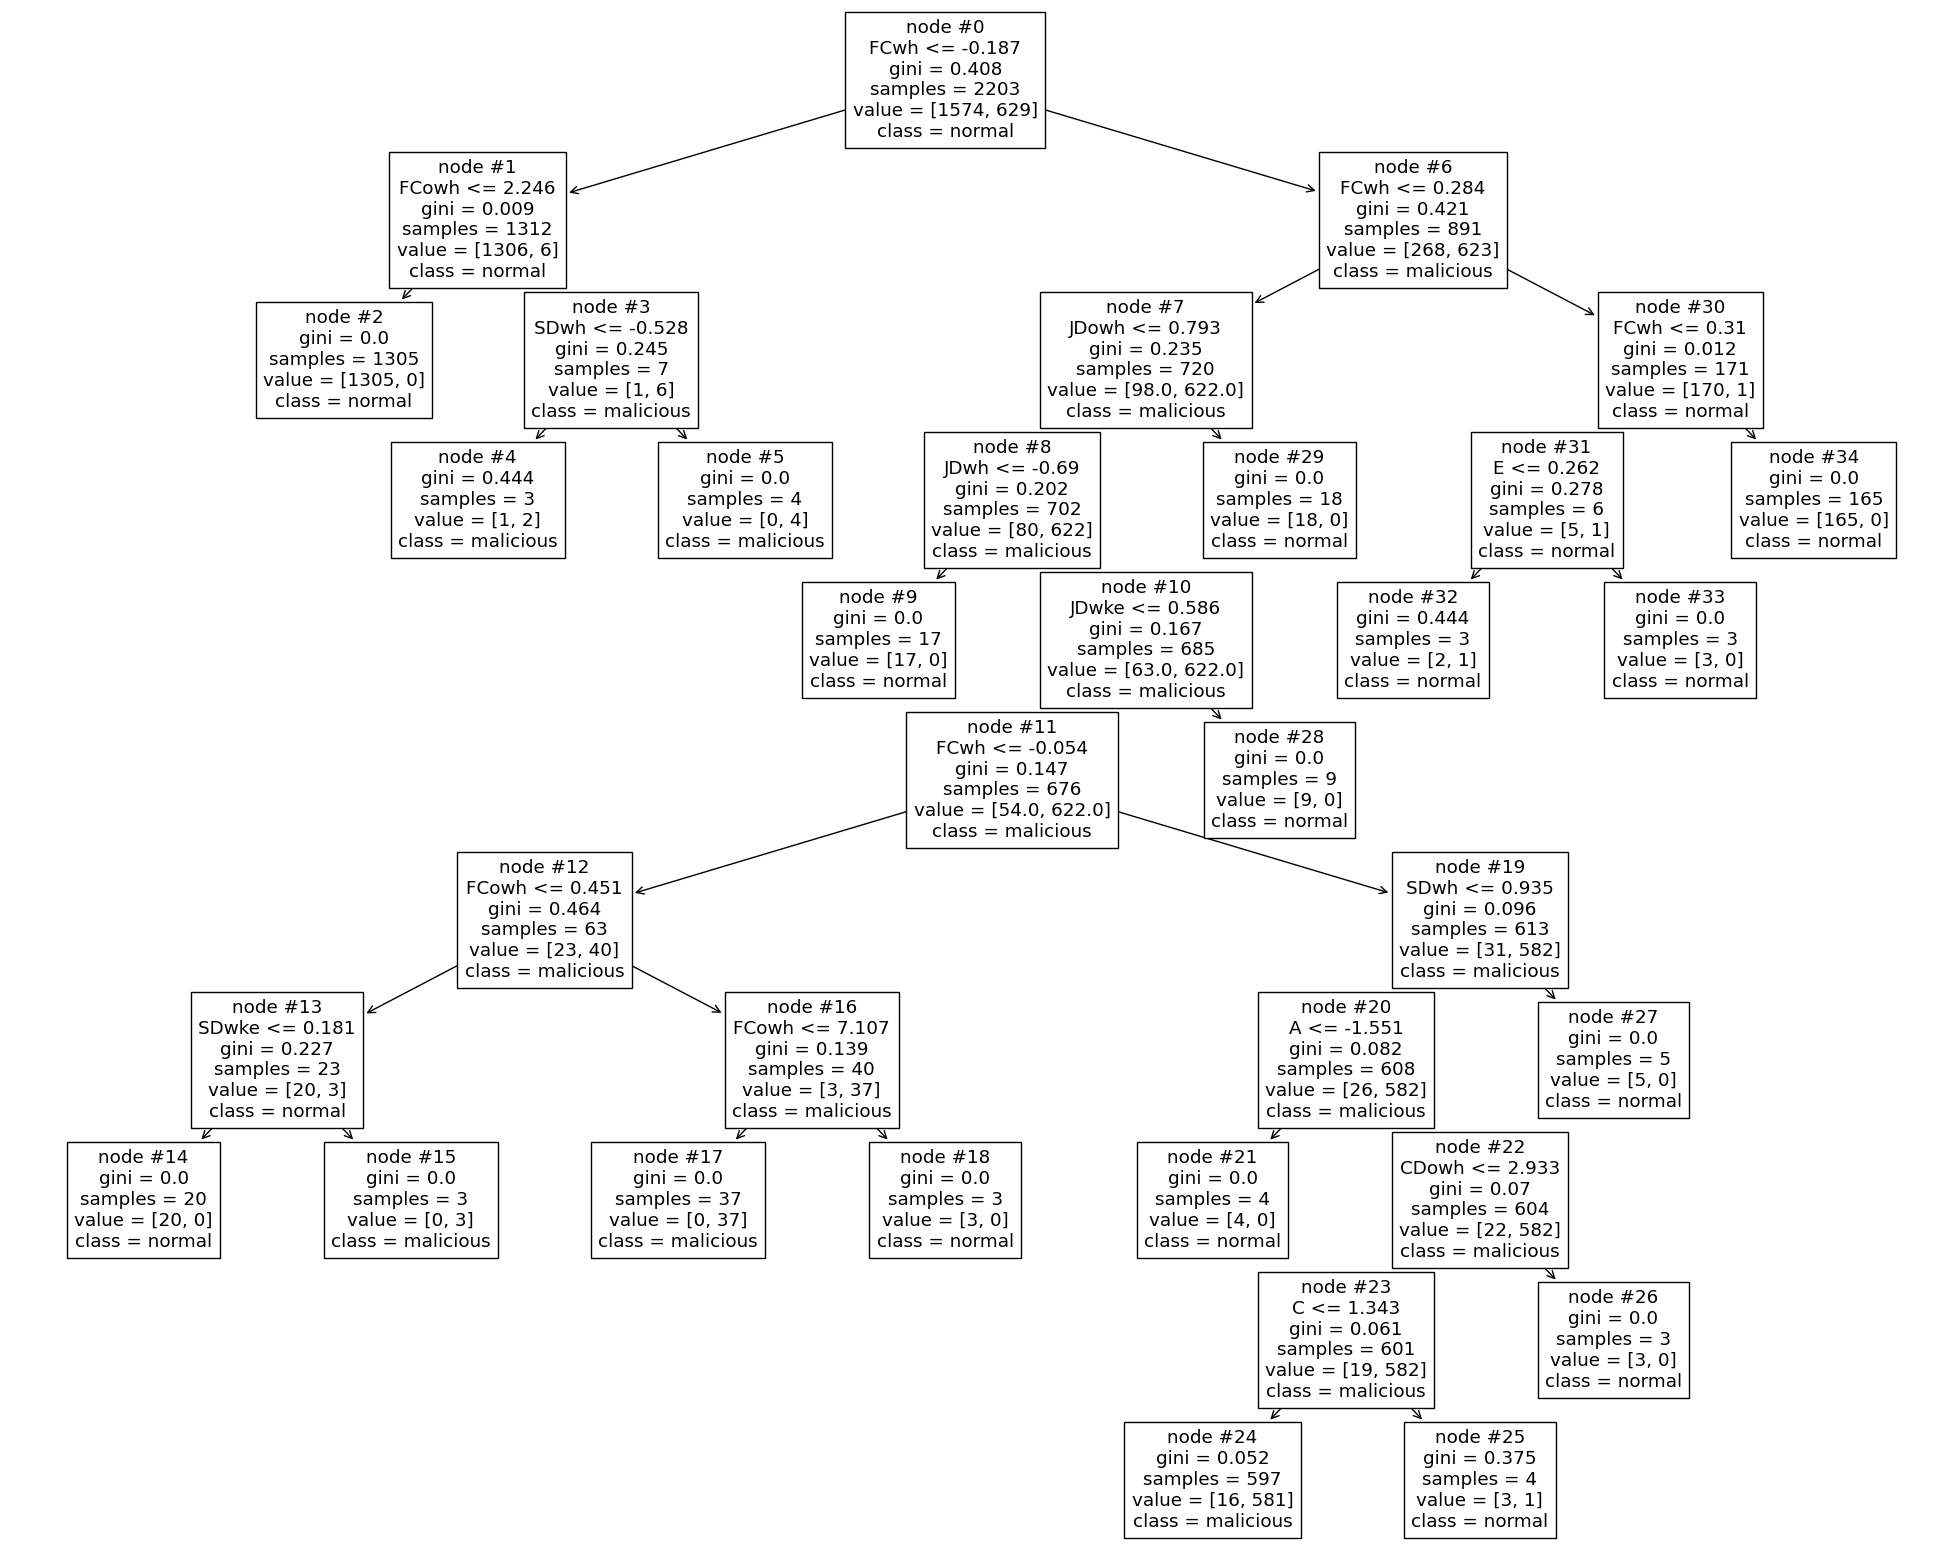

In [17]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns.tolist(),  
                   class_names=["normal","malicious"],
                   node_ids = True)

# Note: Libraries to be Installed

In [18]:
# %pip install scikit-learn == 1.4.2
# %pip install matplotlib == 3.8.4
# %pip install imblearn == 0.12.2